# Assignment

# Trading Places
1. Read in data using Dask __(1 point)__
2. Descriptive Statistics: __(2 points)__
    
    a. In the year 2012, who were the top 10 countries with the most trading partners? What about the bottom 10?
    
    b. Using the designation [here]( https://www.foreign-trade.com/reference/hscode.htm), describe the trade volume of the whole dataset in terms of value and list the five highest value sectors in the entire sample period.

3. Country statistics: __(3 points)__

    a. Calculate the top 10 exports (in terms of value) of our chosen country in 2012.

    b. Calculate the top 10 goods with the highest trade volume for both exports and imports in terms of:
    
        i. Value
    
        ii. Quantity

3. The Gravity Equation Relationship __(4 points)__

    a. Using the country shapefile, calculate the distance in kilometers between the centroid of our chosen country and all the other centroids. You may use either haversine distance with the geographic CRS or use a projected CRS and use the `distance` function of `geopandas`.
    
    b. Using the country we chose in class, create a scatterplot of distance and export volume (quantity and value) in logarithm form.
    
    c. Calculate the correlations between exports and distance for both value and quantity. Interpret the correlations for each of these factors.
    
    d. Using the designation you created in 2.d., for which sectors are exports (quantity) most strongly related to distance for this country?
    
4. Estimation __(6 points)__
    
    a. Create a function called "SSE_1p" that does the following given a scalar input $\beta$:
        1. Subtracts the logarithm of quantity exports from the logarithm of distance times $\beta$.
$$ e = log(E_{ij}) - \beta log(d_{ij}) $$
        2. Squares the error.
        3. Returns the sum of the squared error. 
    b. Plot the function from -1 to +3 with steps of .005, and then find the minimum of the function with the numpy function "argmin." Is it what you expected?
    
    c. Create another function called "SSE_2p" does the same as "SSE_1p" but instead takes a __vector__ as an argument:
 $$ e = log(E_{ij}) - \beta[0] - \beta[1] log(d_{ij})$$
 
     d. Do a grid search with the first parameter range as 1500 to 2500 in steps of 10, and the second parameter range as -1 to +3 in steps of .005 as before. Do it using either `dask` or `multiprocessing`. Comment on how or why the parameter on $log(d_{ij})$ is different than what you found in part 4b.
     
     e. Now check your results using the "econtools" package "reg" function by running OLS with a constant term.
     
     f. Finally, merge in the GDP numbers from the World Bank and do the regression again, except this time the log of each country's GDP as covariates. How did the coefficient on distance change?
     
5. An analyst asks you "for which commodity sectors is distance most important in terms of exporting?" Describe what your economic intuition would say about the answer, and then also map out an analysis strategy for answering their question. As usual, describe: __(4 points)__
    - What data you would need.
    - How you would manipulate the data.
    - What analysis you would run.

In [3]:
import glob
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import json
import dask
import geopandas as gp
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt


def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = row
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# Question 1

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:52892 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.00 GB


In [3]:
df = dd.read_csv('/Users/carri/ACE_592/Homework_3/BACI*.csv')

In [4]:
df.head(5)

,t,i,j,k,v,q
0,2012,4,8,610469,2.734000,0.044
1,2012,4,12,91099,1.185000,1.200
2,2012,4,32,392630,1.274453,0.123
3,2012,4,32,730729,2.018000,0.100
4,2012,4,32,853400,5.530000,0.028


# Question 2

In [5]:
df.partitions[3].compute()

,t,i,j,k,v,q
0,2012,554,36,621520,264.118684,1.524000
1,2012,554,36,621590,13.982460,0.066000
2,2012,554,36,621600,64.804601,1.879000
3,2012,554,36,621710,335.961330,10.766000
4,2012,554,36,621790,5.680674,0.098000
...,...,...,...,...,...,...
1419131,2012,752,381,691200,73.248859,8.535434
1419132,2012,752,381,691310,13.051901,0.096012
1419133,2012,752,381,691390,11.130867,1.116331
1419134,2012,752,381,691490,12.151856,0.719000


In [6]:
df=df.set_index('t',sorted=True)

In [7]:
df.known_divisions

True

### Part A) Top and bottom ten countries by number of trade partners in 2012

In [ ]:
df12=df.loc[2012]

In [ ]:
df12.head(5)

In [ ]:
top_importers = df12.groupby('i').i.count().nlargest(10).compute()
top_importers

In [ ]:
bottom_importers = df12.groupby('i').i.count().nsmallest(10).compute()
bottom_importers

In [ ]:
top_exporters = df12.groupby('j').i.count().nlargest(10).compute()
top_exporters

In [ ]:
bottom_exporters = df12.groupby('j').i.count().nsmallest(10).compute()
bottom_exporters

### Part b) Trade volume values and five  highes value sectors

In [4]:
df = dd.read_csv('/Users/carri/ACE_592/Homework_3/BACI*.csv')

<AxesSubplot:>

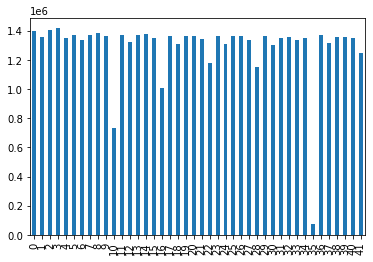

In [9]:
df.map_partitions(len).compute().plot(kind='bar')

<AxesSubplot:>

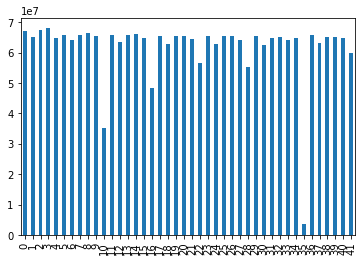

In [10]:
def mem_usage(x): 
    return x.memory_usage().sum()

df.map_partitions(mem_usage).compute().plot(kind='bar')

Below are categorization of item code fails:

##was trying to make categories instead of item codes. 
##Challenge is codes start with zero

#this one is a definite fail
df['k']=df['k'].astype(str)
df['group']='Animal and Animal Product'
df['group']=df['group'].mask(str[2].astype(int)>=6, 'Vegetable Products')
#df.group.loc[df['k'].str[2].astype(int)>=6]='Vegetable Products'
df.head(20)

In [21]:
df['k_sixdigit']=df['k'].mask(df['k']<100000, df['k']*10)
df['k_alt']=df['k']+100000
df.head(40)

,t,i,j,k,v,q,k_sixdigit,k_alt
0,2012,4,8,610469,2.734000,0.044,610469,710469
1,2012,4,12,91099,1.185000,1.200,910990,191099
2,2012,4,32,392630,1.274453,0.123,392630,492630
3,2012,4,32,730729,2.018000,0.100,730729,830729
4,2012,4,32,853400,5.530000,0.028,853400,953400
5,2012,4,32,854140,1.168000,0.069,854140,954140
6,2012,4,36,40310,12.526542,3.492,403100,140310
7,2012,4,36,80212,10.126136,4.120,802120,180212
8,2012,4,36,80620,24.379120,34.157,806200,180620
9,2012,4,36,81310,13.357418,6.030,813100,181310


In [20]:
df['k'].value_counts().compute()

392690    65859
732690    59435
851762    57665
850440    56447
870899    54789
          ...  
252410       73
290892       66
811252       46
293294       45
293963       37
Name: k, Length: 5199, dtype: int64

In [5]:
##Not using k_alt, assuming 5 digit codes are leading zero
df['group']= 'Animal & Animal Products'
df['group']=df['group'].mask(df['k']>=60000, 'Vegetable Products')
df['group']=df['group'].mask(df['k']>=160000, 'Foodstuffs')
df['group']=df['group'].mask(df['k']>=250000, 'Mineral Products')
df['group']=df['group'].mask(df['k']>=280000, 'Chemicals & Allied Industries')
df['group']=df['group'].mask(df['k']>=390000, 'Plastics/Rubbers')
df['group']=df['group'].mask(df['k']>=410000, 'Raw Hides, Skins, Leather, & Furs')
df['group']=df['group'].mask(df['k']>=440000, 'Wood & Wood Products')
df['group']=df['group'].mask(df['k']>=500000, 'Textiles')
df['group']=df['group'].mask(df['k']>=640000, 'Footwear/Headgear')
df['group']=df['group'].mask(df['k']>=680000, 'Stone/Glass')
df['group']=df['group'].mask(df['k']>=720000, 'Metals')
df['group']=df['group'].mask(df['k']>=840000, 'Machinery')
df['group']=df['group'].mask(df['k']>=860000, 'Transportation')
df['group']=df['group'].mask(df['k']>=900000, 'Miscellaneous')

In [ ]:
##another fail at categories
df['group']= 'Animal & Animal Products'
#df.group.loc[df['k_alt']>=160000]='Vegetable Products'
df['group']=df['group'].mask(df['k_alt']>=160000, 'Vegetable Products')
df['group']=df['group'].mask(df['k_alt']>=260000, 'Foodstuffs')
df['group']=df['group'].mask(df['k_alt']>=350000, 'Mineral Products')
df['group']=df['group'].mask(df['k_alt']>=380000, 'Chemicals & Allied Industries')
df['group']=df['group'].mask(df['k_alt']>=490000, 'Plastics/Rubbers')
df['group']=df['group'].mask(df['k_alt']>=510000, 'Raw Hides, Skins, Leather, & Furs')
df['group']=df['group'].mask(df['k_alt']>=540000, 'Wood & Wood Products')
df['group']=df['group'].mask(df['k_alt']>=600000, 'Textiles')
df['group']=df['group'].mask(df['k_alt']>=740000, 'Footwear/Headgear')
df['group']=df['group'].mask(df['k_alt']>=780000, 'Stone/Glass')
df['group']=df['group'].mask(df['k_alt']>=820000, 'Metals')
df['group']=df['group'].mask(df['k_alt']>=940000, 'Machinery')
df['group']=df['group'].mask(df['k_alt']>=960000, 'Transportation')
df['group']=df['group'].mask(df['k_alt']>=1000000, 'Miscellaneous')

In [6]:
df.head(40)

,t,i,j,k,v,q,group
0,2012,4,8,610469,2.734000,0.044,Textiles
1,2012,4,12,91099,1.185000,1.200,Vegetable Products
2,2012,4,32,392630,1.274453,0.123,Plastics/Rubbers
3,2012,4,32,730729,2.018000,0.100,Metals
4,2012,4,32,853400,5.530000,0.028,Machinery
5,2012,4,32,854140,1.168000,0.069,Machinery
6,2012,4,36,40310,12.526542,3.492,Animal & Animal Products
7,2012,4,36,80212,10.126136,4.120,Vegetable Products
8,2012,4,36,80620,24.379120,34.157,Vegetable Products
9,2012,4,36,81310,13.357418,6.030,Vegetable Products


In [7]:
##Changed groupby to "group" and .count to .sum from noah's code
highest_values = df.groupby("group")['v'].sum().nlargest(5).compute() 

In [8]:
highest_values

group
Machinery                        2.960275e+10
Mineral Products                 1.851935e+10
Transportation                   1.245600e+10
Chemicals & Allied Industries    1.142082e+10
Metals                           8.497413e+09
Name: v, dtype: float64

In [4]:
product_codes = pd.read_csv('/Users/carri/ACE_592/Homework_3/product_codes_HS12_V202001.csv')
product_codes = product_codes.rename(columns={'code':'k'})

In [5]:
df_wdes = df.merge(product_codes)

In [6]:
countries = pd.read_csv("/Users/carri/ACE_592/Homework_3/country_codes_V202001.csv",encoding = "ISO-8859-1")
countries = countries.rename(columns={"country_code":"i","country_name_full":"name_i"})
df_wdes = df_wdes.merge(countries[['i','name_i']])

countries = pd.read_csv("/Users/carri/ACE_592/Homework_3/country_codes_V202001.csv",encoding = "ISO-8859-1")
countries = countries.rename(columns={"country_code":"j","country_name_full":"name_j"})
df_wdes = df_wdes.merge(countries[['j','name_j']])

In [7]:
Largest_values = df_wdes.groupby("description")['v'].count().nlargest(5).compute()

In [8]:
Largest_values1 = df_wdes.groupby("description")['q'].count().nlargest(5).compute()

In [9]:
Largest_values

description
Plastics: other articles n.e.c. in chapter 39                                                                                                                                                                             65859
Iron or steel: articles n.e.c.in heading 7326                                                                                                                                                                             59435
Communication apparatus (excluding telephone sets or base stations): machines for the reception, conversion and transmission or regeneration of voice, images or other data, including switching and routing apparatus    57665
Electrical static converters                                                                                                                                                                                              56447
Vehicle parts and accessories: n.e.c. in heading no. 8708                                   

In [10]:
Largest_values1

description
Plastics: other articles n.e.c. in chapter 39                                                                                                                                                                             65859
Iron or steel: articles n.e.c.in heading 7326                                                                                                                                                                             59435
Communication apparatus (excluding telephone sets or base stations): machines for the reception, conversion and transmission or regeneration of voice, images or other data, including switching and routing apparatus    57665
Electrical static converters                                                                                                                                                                                              56447
Vehicle parts and accessories: n.e.c. in heading no. 8708                                   

# Question 3

### a) Top 10 exports by value for Brazil

In [ ]:
df_2012 = df_wdes.loc[2012]
#df_2012

In [ ]:
df_2012_brazil = df_2012.groupby(["name_i", "v"])

#### Below two lines give me errors, cannot get top 10 exports

In [ ]:
df_2012_brazil.get_group("Brazil")["v"].count().nlargest(10).compute()  

In [ ]:
Brazil_top_exports = df_2012.groupby("Brazil")['v'].count().nlargest(10).compute()

b) Top 10 goods with highest trade volume in entire dataset in terms of both VALUE and QUANTITY

# Question 4) Gravity Equation

### a) Calculate distances from other centroids

In [ ]:
countries='/Users/carri/ACE_592/Homework_3/countries.geojson'
country=gp.read_file(countries)

In [ ]:
country.loc[country['ADMIN']=='Brazil']

In [ ]:
country.plot()

In [ ]:
country=country.to_crs(epsg=4087)

In [ ]:
f,a = plt.subplots()
country.plot(ax=a)
country.centroid.plot(ax=a, color='red', markersize=5)

In [ ]:
brazilcent=country.centroid[33]

In [ ]:
country['brazil_dist'] = country.centroid.distance(brazilcent)/1000 # res is in meters, so converting to km
country.sort_values("brazil_dist").head()

In [ ]:
f,a = plt.subplots(figsize=(15,5))
country.plot(column="brazil_dist", # The data it uses to assign colors
                  ax=a,\
                  legend=True,\
                  legend_kwds={'label': "Centroid Distance (km)"});
country.centroid[:1].plot(color="C3",ax=a,markersize=10);
country.centroid[1:].plot(color="w",ax=a,markersize=5);

plt.axis("off");
plt.title("Country Centroid Distance from Brazil")


### b) Create scatterplot with centroid distance (x) and export volume (y, both quantity and value from question 3b) in log form 

### c) Correlation exports and distance for both value and quantity, interpret these correlations

### d) from 2b, which sectors are export quantity most related to distance

Won't work with dictionary, may need to go back and actually assign item codes (potentially add value to codes to make everything 6 digit)

# Question 5) Estimation